In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold
import warnings 
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = '/home/hoosierai/Documents/fastai/amlProject/'

# Directory to save trained model
ROOT_DIR = '/home/hoosierai/Documents/fastai/amlProject/working'

# Download the Mask_RCNN implementation by matterport 

In [3]:
# !git clone https://www.github.com/matterport/Mask_RCNN.git
# os.chdir('Mask_RCNN')

In [4]:
sys.path.append('/home/hoosierai/Documents/fastai/amlProject/Mask_RCNN') 
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


# Training directory and Testing Directory paths

In [5]:
train_dicom_dir = '/home/hoosierai/Documents/fastai/amlProject/stage_2_train_images'
test_dicom_dir = '/home/hoosierai/Documents/fastai/amlProject/stage_2_test_images'

# # Download the pre-trained weights of Mask RCNN trained on COCO Dataset

In [6]:
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
# !ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

# Functions to parse the .dcm files provided by Competetion hosts

In [7]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

# Configuration settings for our RCNN training model with Resnet101

To train the model on our own dataset we'll need to extend two classes:<br/>
**Config** This class contains the default configuration. We will subclass it and modify the attributes that needs to change.

**Dataset** This class provides a consistent way to work with any dataset. It allows you to use new datasets for training without having to change the code of the model.

In [8]:

class DetectorConfig(Config):
    
    NAME = 'pneumoniaRSNA'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet101'
    
    NUM_CLASSES = 2  
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Dataset class for training pneumonia detection on the RSNA pneumonia dataset.

In [9]:
class DetectorDataset(utils.Dataset):


    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)


## Read dcm images from filepath  and get the 3d RGB array for these images

In [10]:
anns = pd.read_csv('/home/hoosierai/Documents/fastai/amlProject/stage_2_train_labels.csv')
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)
ds = pydicom.read_file(image_fps[0]) 
image = ds.pixel_array # get image array
ORIG_SIZE = 1024
# print(image.shape)

# Setup validation dataset with 1500 images and 25,000 training images

In [11]:
image_fps_list = list(image_fps)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

25184 1500


## Prepare the training dataset

In [12]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

## Prepare the validation dataset 

In [13]:
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

## Random image with mask 

(1024, 1024, 3)
/home/hoosierai/Documents/fastai/amlProject/stage_2_train_images/c9a95d7f-8a6f-49c5-88d3-8a1cfaaf51a4.dcm
[1]


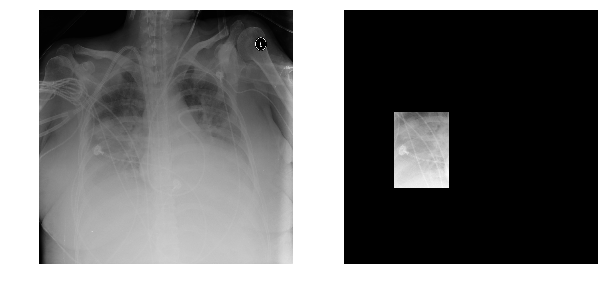

In [14]:
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

## Image augmentation

Due to the small size of our training dataset compared to the model that we're gonna use, we'll augment the current image set using affine transformations, changing the contrast of image and blurring/sharpening the images.

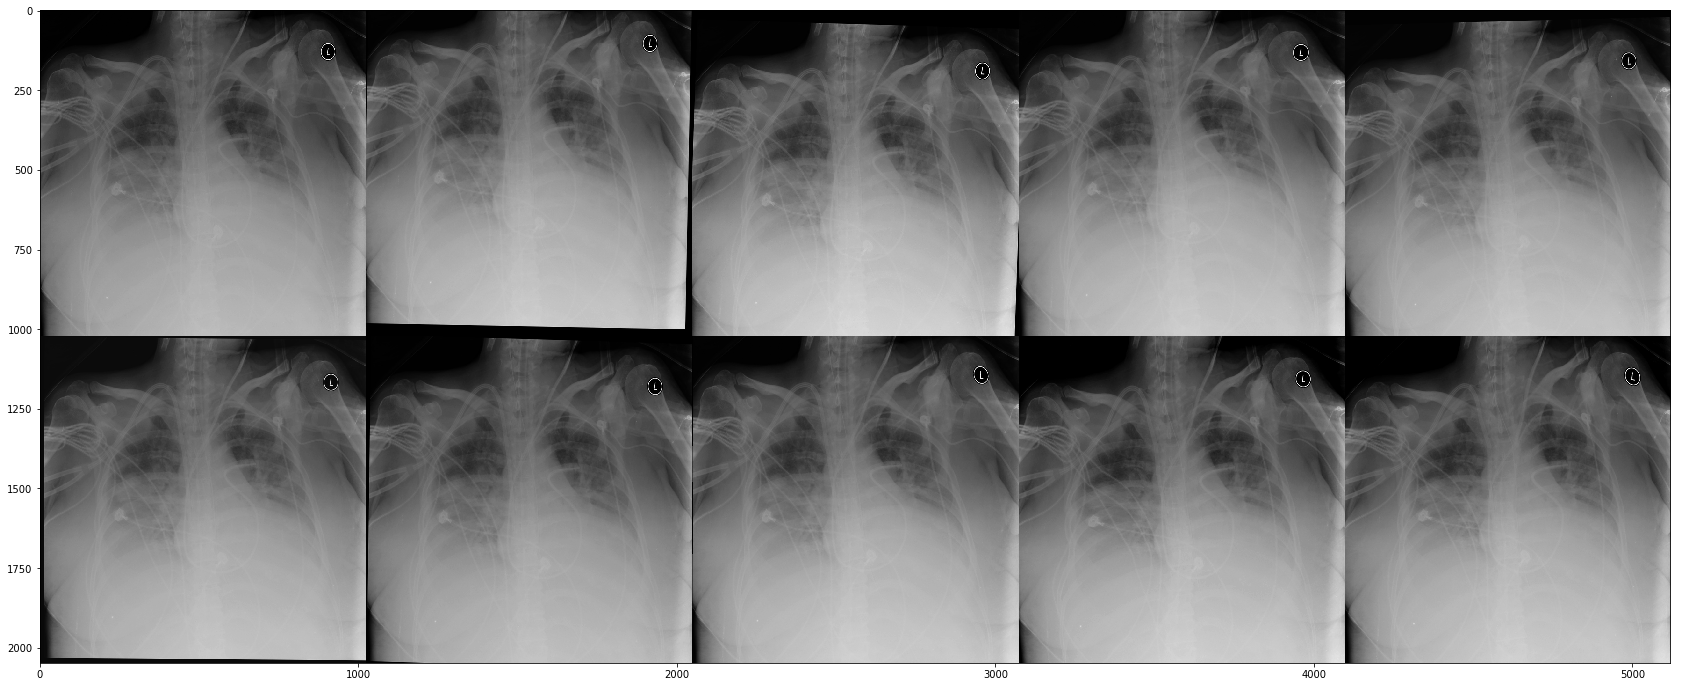

In [15]:
augmentation = iaa.Sequential([
    ## Affine transformation
    iaa.OneOf([ 
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    ## Change contrast
    iaa.OneOf([ 
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    ## Gaussian blur or sharpen
    iaa.OneOf([ 
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on some random image
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
random = plt.imshow(imggrid[:, :, 0], cmap='gray')

## Loading pretrained weights from COCO  Dataset

When we load weights, we had to exclude the last layer weights because it will require us to have the same number of classes in our dataset as that of COCO Dataset

In [16]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [17]:
LEARNING_RATE = 0.004

# Train Mask-RCNN Model 


# Train only the last layers and use pre-trained weights for inner layers

In [18]:
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet


history = model.keras_model.history.history


Starting at epoch 0. LR=0.004

Checkpoint Path: /home/hoosierai/Documents/fastai/amlProject/working/pneumoniarsna20181124T2100/mask_rcnn_pneumoniarsna_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_c

# Train all the layers along with image augmentation

In [19]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=20,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.0008

Checkpoint Path: /home/hoosierai/Documents/fastai/amlProject/working/pneumoniarsna20181124T2100/mask_rcnn_pneumoniarsna_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
re

Epoch 3/20
200/200 [==============================] - 210s 1s/step - loss: 1.2979 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3837 - mrcnn_class_loss: 0.1628 - mrcnn_bbox_loss: 0.3487 - mrcnn_mask_loss: 0.3889 - val_loss: 1.9852 - val_rpn_class_loss: 0.0194 - val_rpn_bbox_loss: 0.8887 - val_mrcnn_class_loss: 0.1918 - val_mrcnn_bbox_loss: 0.4387 - val_mrcnn_mask_loss: 0.4465
Epoch 4/20
200/200 [==============================] - 117s 585ms/step - loss: 0.9667 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2366 - mrcnn_class_loss: 0.1219 - mrcnn_bbox_loss: 0.2545 - mrcnn_mask_loss: 0.3425 - val_loss: 1.8299 - val_rpn_class_loss: 0.0159 - val_rpn_bbox_loss: 0.6058 - val_mrcnn_class_loss: 0.2777 - val_mrcnn_bbox_loss: 0.4471 - val_mrcnn_mask_loss: 0.4834
Epoch 5/20
200/200 [==============================] - 121s 607ms/step - loss: 0.9145 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.1229 - mrcnn_bbox_loss: 0.2315 - mrcnn_mask_loss: 0.3280 - val_loss: 1.6438 - val_rpn_c

## See the change in validation loss with each epoch and pick the epoch with the least loss

In [20]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.960440,0.021685,0.605966,0.259775,0.624110,0.448902,1.488463,0.019078,0.398309,0.195499,0.442330,0.433244
2,2.124456,0.018073,0.822510,0.304748,0.539492,0.439631,1.224500,0.015228,0.320116,0.155980,0.356937,0.376236
3,1.985196,0.019428,0.888664,0.191830,0.438720,0.446548,1.297914,0.013832,0.383673,0.162807,0.348713,0.388880
4,1.829882,0.015916,0.605817,0.277663,0.447092,0.483387,0.966738,0.011344,0.236579,0.121884,0.254471,0.342451
5,1.643752,0.011462,0.539374,0.158796,0.487840,0.446272,0.914475,0.010140,0.221841,0.122938,0.231528,0.328022
6,1.677197,0.011637,0.499256,0.210710,0.483299,0.472287,0.881666,0.008154,0.229846,0.103868,0.216738,0.323052
7,1.796944,0.014795,0.787491,0.177607,0.380765,0.436279,0.855043,0.007037,0.226024,0.105614,0.206105,0.310255
8,1.625811,0.009258,0.642033,0.128914,0.418847,0.426751,0.881056,0.006710,0.244317,0.095246,0.210546,0.324230
9,1.670933,0.013980,0.522643,0.229737,0.453350,0.451215,0.883534,0.007646,0.231632,0.116567,0.210320,0.317362
10,1315.891166,29.610858,1284.973537,0.271002,0.520760,0.514982,0.802180,0.006463,0.186363,0.113366,0.196421,0.299559


## Load the weights of the trained model with the least validation loss

In [21]:
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    
    dir_name = os.path.join(model.model_dir, d)
    print(dir_name)
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-7])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

/home/hoosierai/Documents/fastai/amlProject/working/pneumoniarsna20181124T1643
/home/hoosierai/Documents/fastai/amlProject/working/pneumoniarsna20181124T2008
/home/hoosierai/Documents/fastai/amlProject/working/pneumoniarsna20181124T2100
Found model /home/hoosierai/Documents/fastai/amlProject/working/pneumoniarsna20181124T2100/mask_rcnn_pneumoniarsna_0014.h5
Loading weights from  /home/hoosierai/Documents/fastai/amlProject/working/pneumoniarsna20181124T2100/mask_rcnn_pneumoniarsna_0014.h5
Re-starting from epoch 14


## Set color for Bounding Boxes

In [22]:

def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

## Visualize predictions on the validation dataset 

In [ ]:

import random
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(2):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

## Load test images,make predictions and create submission.csv

In [24]:
test_image_fps = get_dicom_fps(test_dicom_dir)

def predict(image_fps, filepath='submission.csv', min_conf=0.95):

    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [25]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [03:16<00:00, 15.43it/s]

/home/hoosierai/Documents/fastai/amlProject/working/submission.csv
